# Imports


In [1]:
import matplotlib.pyplot as plt
from essentia.standard import *
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

# Load Samples


In [2]:
tri = essentia.standard.MonoLoader(
    filename="/Users/javierechavarri/Library/Mobile Documents/com~apple~CloudDocs/TFG/new_samples/Tri_440Hz_Cut_1.wav"
)
tri1 = essentia.standard.MonoLoader(
    filename="/Users/javierechavarri/Library/Mobile Documents/com~apple~CloudDocs/TFG/new_samples/Tri+_440Hz_Cut_1.wav"
)
trisaw = essentia.standard.MonoLoader(
    filename="/Users/javierechavarri/Library/Mobile Documents/com~apple~CloudDocs/TFG/new_samples/TriSaw_440Hz_Cut_1.wav"
)
trisaw1 = essentia.standard.MonoLoader(
    filename="/Users/javierechavarri/Library/Mobile Documents/com~apple~CloudDocs/TFG/new_samples/TriSaw+_440Hz_Cut_1.wav"
)
saw = essentia.standard.MonoLoader(
    filename="/Users/javierechavarri/Library/Mobile Documents/com~apple~CloudDocs/TFG/new_samples/Saw_440Hz_Cut_1.wav"
)

tri_audio = tri().copy()
tri1_audio = tri1().copy()
trisaw_audio = trisaw().copy()
trisaw1_audio = trisaw1().copy()
saw_audio = saw().copy()

sample_dict = {
    "tri": tri_audio,
    "tri+": tri1_audio,
    "trisaw": trisaw_audio,
    "trisaw+": trisaw1_audio,
    "saw": saw_audio,
}

In [3]:
# Train data with potentiometer values for each period
data = np.stack(
    (
        sample_dict["tri"],
        sample_dict["tri+"],
        sample_dict["trisaw"],
        sample_dict["trisaw+"],
        sample_dict["saw"],
    )
)
pot_values = np.array([0, 0.25, 0.5, 0.75, 1])
print(pot_values.shape)

(5,)


# Lin inter


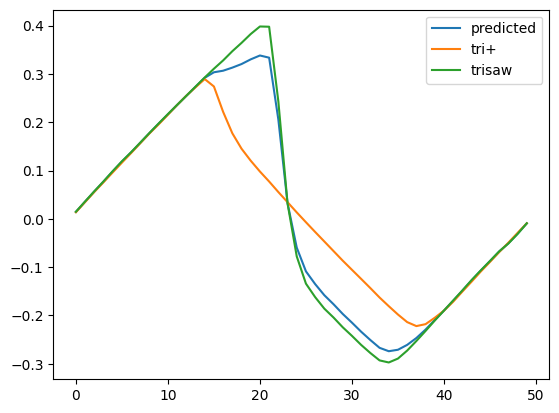

In [4]:
from scipy.interpolate import interp1d


def predicted_output_lininter(pot_value):
    if pot_value < 0 or pot_value > 1:
        raise ValueError("Pot Value must be between 0 and 1")
    interpolator = interp1d(pot_values, data, axis=0, kind="linear")
    return interpolator(pot_value)


test_pot_value = 0.45
output = predicted_output_lininter(test_pot_value)
plt.plot(output, label="predicted")
plt.plot(data[1], label="tri+")
plt.plot(data[2], label="trisaw")
plt.legend()
plt.show()

# multi Polynomial regression


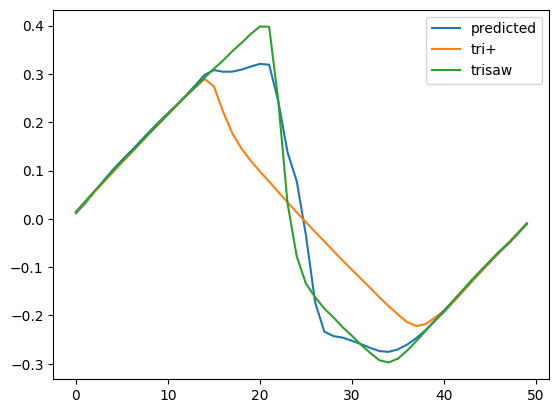

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

deg = 3
pot_values_reshaped = pot_values.reshape(-1, 1)
poly_features = PolynomialFeatures(degree=deg)
pot_values_poly = poly_features.fit_transform(pot_values_reshaped)

model = LinearRegression()
model.fit(pot_values_poly, data)


def predicted_output_multipolreg(pot_value):
    if pot_value < 0 or pot_value > 1:
        raise ValueError("Pot value must be between 0 and 1")
    pot_value_poly = poly_features.transform(np.array([[pot_value]]))
    return model.predict(pot_value_poly).flatten()


test_pot_value = 0.5
output = predicted_output_multipolreg(test_pot_value)
plt.plot(output, label="predicted")
plt.plot(data[1], label="tri+")
plt.plot(data[2], label="trisaw")
plt.legend()
plt.show()

# Barycentric Interpol


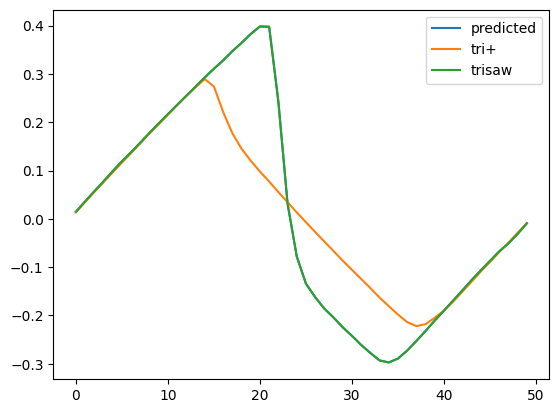

In [6]:
from scipy.interpolate import BarycentricInterpolator

interpolators = [
    BarycentricInterpolator(pot_values, data[:, i]) for i in range(data.shape[1])
]


def predicted_output_baryinter(pot_value):
    if pot_value < 0 or pot_value > 1:
        raise ValueError("Pot Value needs to be between 0 and 1")
    return np.array([interpolators[i](pot_value) for i in range(len(interpolators))])


test_pot_value = 0.5
output = predicted_output_baryinter(test_pot_value)
plt.plot(output, label="predicted")
plt.plot(data[1], label="tri+")
plt.plot(data[2], label="trisaw")
plt.legend()
plt.show()

# Radial Basis Function Interpol


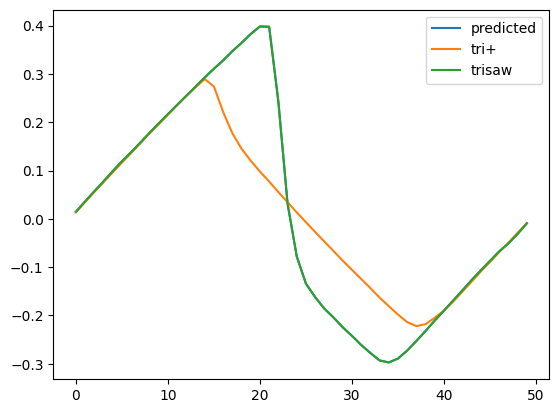

In [7]:
from scipy.interpolate import Rbf

interpolators = [
    Rbf(pot_values, data[:, i], function="multiquadric") for i in range(data.shape[1])
]


def predicted_output_rbf(pot_value):
    if pot_value < 0 or pot_value > 1:
        raise ValueError("Pot value needs to be between 0 and 1")
    return np.array([interpolators[i](pot_value) for i in range(len(interpolators))])


test_pot_value = 0.5
output = predicted_output_rbf(test_pot_value)
plt.plot(output, label="predicted")
plt.plot(data[1], label="tri+")
plt.plot(data[2], label="trisaw")
plt.legend()
plt.show()

# Random Forest


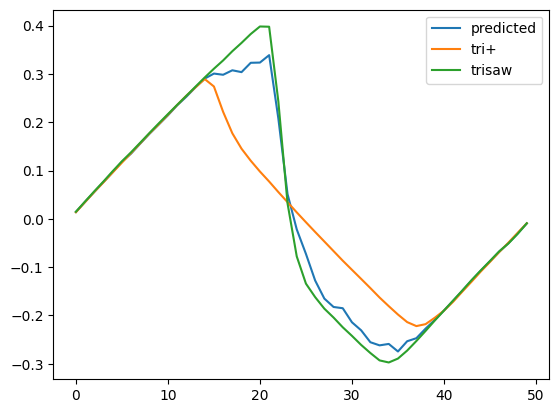

In [8]:
from sklearn.ensemble import RandomForestRegressor

models = [
    RandomForestRegressor().fit(pot_values.reshape(-1, 1), data[:, i])
    for i in range(data.shape[1])
]


def predicted_output_randomforest(pot_value):
    if pot_value < 0 or pot_value > 1:
        raise ValueError("pot value needs to be between 0 and 1")
    return np.array([models[i].predict([[pot_value]])[0] for i in range(len(models))])


test_pot_value = 0.5
output = predicted_output_randomforest(test_pot_value)
plt.plot(output, label="predicted")
plt.plot(data[1], label="tri+")
plt.plot(data[2], label="trisaw")
plt.legend()
plt.show()

# K neighbors


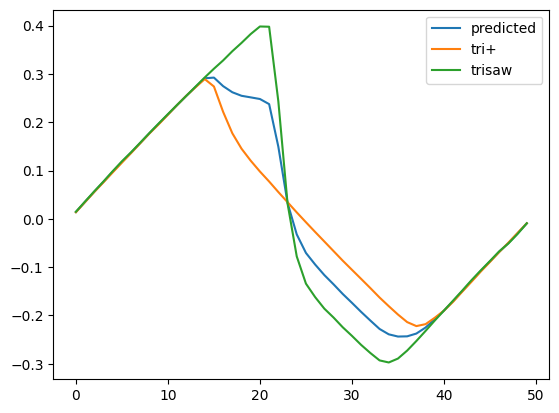

In [9]:
from sklearn.neighbors import KNeighborsRegressor

models = [
    KNeighborsRegressor(n_neighbors=2).fit(pot_values.reshape(-1, 1), data[:, i])
    for i in range(data.shape[1])
]


def predicted_output_kneighbors(pot_value):
    if pot_value < 0 or pot_value > 1:
        raise ValueError("pot value needs to be between 0 and 1")
    return np.array([models[i].predict([[pot_value]])[0] for i in range(len(models))])


test_pot_value = 0.35
output = predicted_output_kneighbors(test_pot_value)
plt.plot(output, label="predicted")
plt.plot(data[1], label="tri+")
plt.plot(data[2], label="trisaw")
plt.legend()
plt.show()

# Plot of all the techniques working


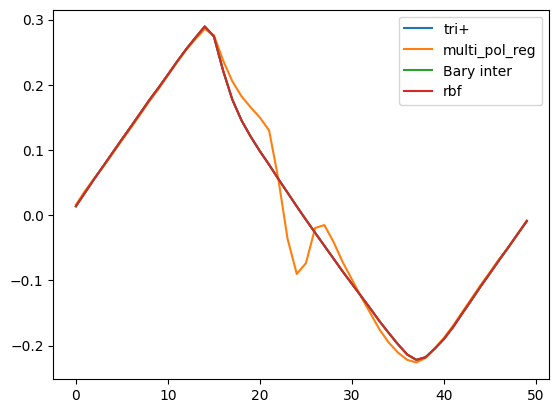

In [17]:
test_pot_value = 0.25
linear_inter = predicted_output_lininter(test_pot_value)
multi_pol_reg = predicted_output_multipolreg(test_pot_value)
bary_inter = predicted_output_baryinter(test_pot_value)
rbf = predicted_output_rbf(test_pot_value)
random_forest = predicted_output_randomforest(test_pot_value)
k_neighbors = predicted_output_kneighbors(test_pot_value)

plt.plot(data[1], label="tri+")
# plt.plot(linear_inter, label="linear inter")
# plt.plot(multi_pol_reg, label="multi_pol_reg")
plt.plot(bary_inter, label="Bary inter")
plt.plot(rbf, label="rbf")
# plt.plot(random_forest, label="random forest")
# plt.plot(k_neighbors, label="k_neighbors")
plt.legend()
plt.show()